# Predicting solubility using the ATOM Modeling Pipeline (AMPL) on the public Delaney solubility dataset

In this notebook, we describe the AMPL used to curate a public dataset, fit a simple model to predict solubility from chemical structure, and predict solubility for withheld compounds.

## Set up
We first import the AMPL modules for use in this notebook.

The relevant AMPL modules for this example are listed below:

|module|Description|
|-|-|
|`atomsci.ddm.pipeline.model_pipeline`|The model pipeline module is used to fit models and load models for prediction.|
|`atomsci.ddm.pipeline.parameter_parser`|The parameter parser reads through pipeline options for the model pipeline.|
|`atomsci.ddm.utils.curate_data`|The curate data module is used for data loading and pre-processing.|
|`atomsci.ddm.utils.struct_utils`|The structure utilities module is used to process loaded structures.|
|`atomsci.ddm.pipeline.perf_plots`|Perf plots contains a variety of plotting functions.|

In [3]:
# We temporarily disable warnings for demonstration.
# FutureWarnings and DeprecationWarnings are present from some of the AMPL dependency modules.
import warnings
warnings.filterwarnings('ignore')

import json
import numpy as np
import pandas as pd
import os
import requests
import sys

import atomsci.ddm.pipeline.model_pipeline as mp
import atomsci.ddm.pipeline.parameter_parser as parse
import atomsci.ddm.utils.curate_data as curate_data
import atomsci.ddm.utils.struct_utils as struct_utils
from atomsci.ddm.pipeline import perf_plots as pp


## Data curation

We then download and do very simple curation to the related dataset.

We need to set the directory we want to save files to. Next we download the dataset.

In [4]:
working_dir = '/usr/local/data'

In [5]:
# Download the Delaney dataset
dataset_file = os.path.join(working_dir, 'delaney-processed.csv')
if (not os.path.isfile(dataset_file)):
    r = requests.get('http://deepchem.io.s3-website-us-west-1.amazonaws.com/datasets/delaney-processed.csv', verify=True)
    with open(dataset_file, 'wb') as f:
        f.write(r.content)

Next, we load the downloaded dataset, and process the compound structures:

In [6]:
# Load the Delaney dataset
raw_df = pd.read_csv(dataset_file)

# Generate SMILES, InChI keys for dataset with curation and structure modules.
# RDkit modules are used to process the SMILES strings
raw_df['rdkit_smiles'] = raw_df['smiles'].apply(curate_data.base_smiles_from_smiles)
raw_df['inchi_key'] = raw_df['smiles'].apply(struct_utils.smiles_to_inchi_key)

data = raw_df
data['compound_id'] = data['inchi_key']

The next step is to address the case where we have multiple measurements for a single structure (by RDkit canonical SMILEs string). We have a function in the `curate_data()` module to address process compounds. The function parameters are listed below along with an explanation of each parameter:

In [7]:
# column: Response values column
column = 'measured log solubility in mols per litre'

# tolerance: Percentage of individual respsonse values allowed to different from the average to be included in averaging
tolerance = 10

# list_bad_duplicates: Print structures with bad duplicates
list_bad_duplicates = 'Yes'

# max_std: Maximum allowed standard deviation for computed average response value
# NOTE: In this example, we set this value very high to disable this feature
max_std = 100000

# compound_id: Compound ID column
compound_id = 'compound_id'

# smiles_col: SMILES column
smiles_col = 'rdkit_smiles'

curated_df = curate_data.average_and_remove_duplicates(column, tolerance, list_bad_duplicates, data, max_std,
                                                       compound_id=compound_id, smiles_col=smiles_col)
curated_file = os.path.join(working_dir, 'delaney_curated.csv')
curated_df.to_csv(curated_file, index=False)

Bad duplicates removed from dataset
Dataframe size (1128, 17)
List of 'bad' duplicates removed
Empty DataFrame
Columns: [compound_id, measured log solubility in mols per litre, VALUE_NUM_mean, Perc_Var, VALUE_NUM_std]
Index: []

Dataset de-duplicated
Dataframe size (1117, 17)
New column created with averaged values:  VALUE_NUM_mean


Now that we have a curated dataset, we decide what type of featurizer and model we would like. See documentation for all available options. We also set the name of the new averaged response value column.

In [8]:
featurizer = 'ecfp'
model_type = 'RF'
response_cols = ['VALUE_NUM_mean']

Next we set up the parameters for our model. We set datastore and save_results to False to indicate that we are reading the input file and saving the results directly to the file system. There are a wide range of settable parameters; see the documentation for more details.

In [9]:
params={"datastore": "False",
        "save_results": "False",
        "id_col": compound_id,
        "smiles_col": smiles_col,
        "response_cols": response_cols,
        "featurizer": featurizer,
        "model_type": model_type,
        "result_dir": working_dir,
        "dataset_key": curated_file}

We use parse.wrapper to process our input configuration. We then build the model pipeline, train the model, and plot the predicted versus true values for our train, valid, test sets.

2019-12-05 23:35:26,946 Splitting data by scaffold


number of features: 1024


2019-12-05 23:35:29,435 Dataset split table saved to /usr/local/data/delaney_curated_train_valid_test_scaffold_ad460782-3a43-462b-9c98-a7be72ed6a9d.csv


n_cnt [1117.]
y_means [-3.05005819]
y_stds [2.09451877]
TIMING: dataset construction took 0.302 s
Loading dataset from disk.
TIMING: dataset construction took 0.017 s
Loading dataset from disk.
TIMING: dataset construction took 0.017 s
Loading dataset from disk.


2019-12-05 23:35:34,791 Wrote model metadata to file /usr/local/data/delaney_curated/RF_ecfp_scaffold_regression/45423d3c-717c-4972-90fe-ae6d407f8ee3/model_metadata.json
2019-12-05 23:35:34,798 Wrote model metrics to file /usr/local/data/delaney_curated/RF_ecfp_scaffold_regression/45423d3c-717c-4972-90fe-ae6d407f8ee3/training_model_metrics.json


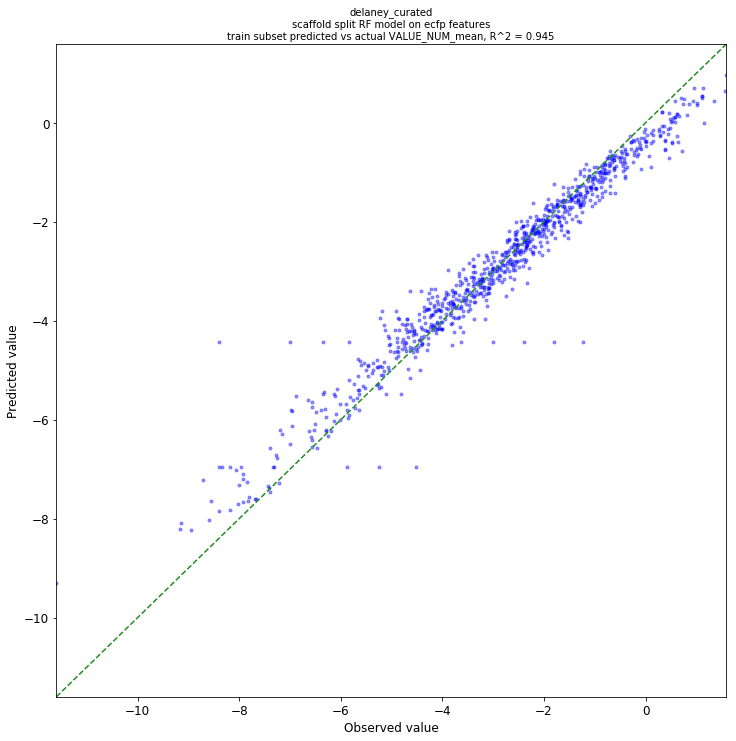

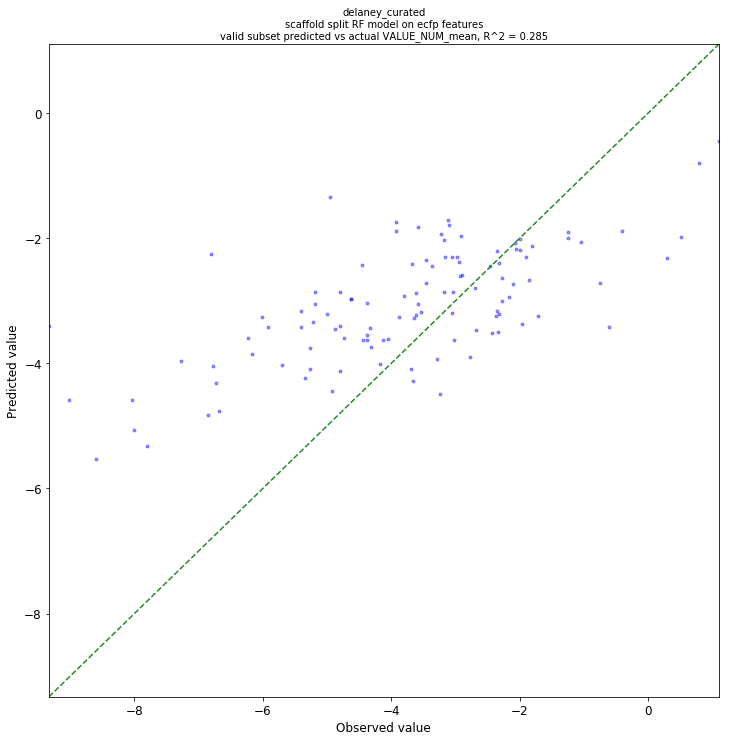

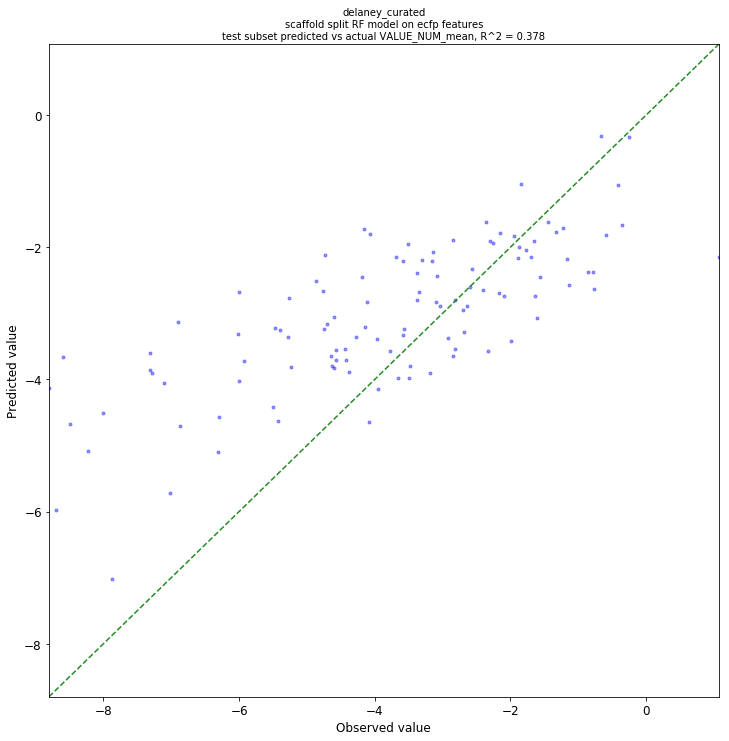

In [10]:
pparams = parse.wrapper(params)
MP = mp.ModelPipeline(pparams)
MP.train_model()
pp.plot_pred_vs_actual(MP)